Проект для «Викишоп» c BERT.

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**В данной работе нам требуется:**

1. Загрузите и подготовьте данные.
2. Обучите разные модели.
3. Сделайте выводы.

In [1]:
# !pip install optuna
# !pip install optuna-integration
# !pip install missingno

# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install transformers
# !pip install tqdm
# !pip install --upgrade transformers datasets
# !pip install sentencepiece
# !pip install -U spacy
# !pip install -U pip setuptools wheel
# !python -m spacy download en_core_web_sm




In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import make_scorer, mean_squared_error, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import optuna
from optuna.integration import OptunaSearchCV
from optuna.visualization import plot_contour
from catboost import CatBoostRegressor, CatBoostClassifier
import missingno as msno

import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import transformers
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, DataCollatorWithPadding, DistilBertTokenizer, DistilBertModel, AutoModel, AutoTokenizer, AdamW

from tqdm import tqdm
from tqdm import notebook 
from datasets import Dataset as HFDataset

import spacy
torch.cuda.is_available()

True

### Шаг 1. Загрузка данных

In [3]:
try:
    toxic_comments = pd.read_csv('datasets/toxic_comments.csv')
except:   
    toxic_comments = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')


In [4]:
toxic_comments = toxic_comments.sample(1000).reset_index(drop=True)
toxic_comments.head(20)

,Unnamed: 0,text,toxic
0,140022,I cared enough to find all the reliable source...,0
1,7427,poster \n\nI have sent the e-mail. -Garrett,0
2,23010,"""\nAs an internationalist who wants nothing mo...",0
3,13341,Why do you keep removing links from the BB 200...,0
4,132282,"""\nI guess we can't accommodate for people's i...",0
5,9776,It wouldn't hurt to ask the copyedit guild to ...,0
6,66240,"""\n\nHeh, alright. I was nearly in """"sweet fu...",1
7,107046,What is your version of IE? —— Eagle (ask me f...,0
8,57445,"""\n\n Okay, then let's turn it around: I don't...",0
9,100892,"""\n\n IP range blocks \n\nHi! How do IP range ...",0


In [5]:
toxic_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1000 non-null   int64 
 1   text        1000 non-null   object
 2   toxic       1000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 23.6+ KB


**Вывод: Данные соответсвуют описанию и готовы к предобработке.**

### Шаг 2. Изучение данных

Проверка на дубликаты:

In [6]:
toxic_comments.duplicated().sum()

0

Проверка на пропуски:

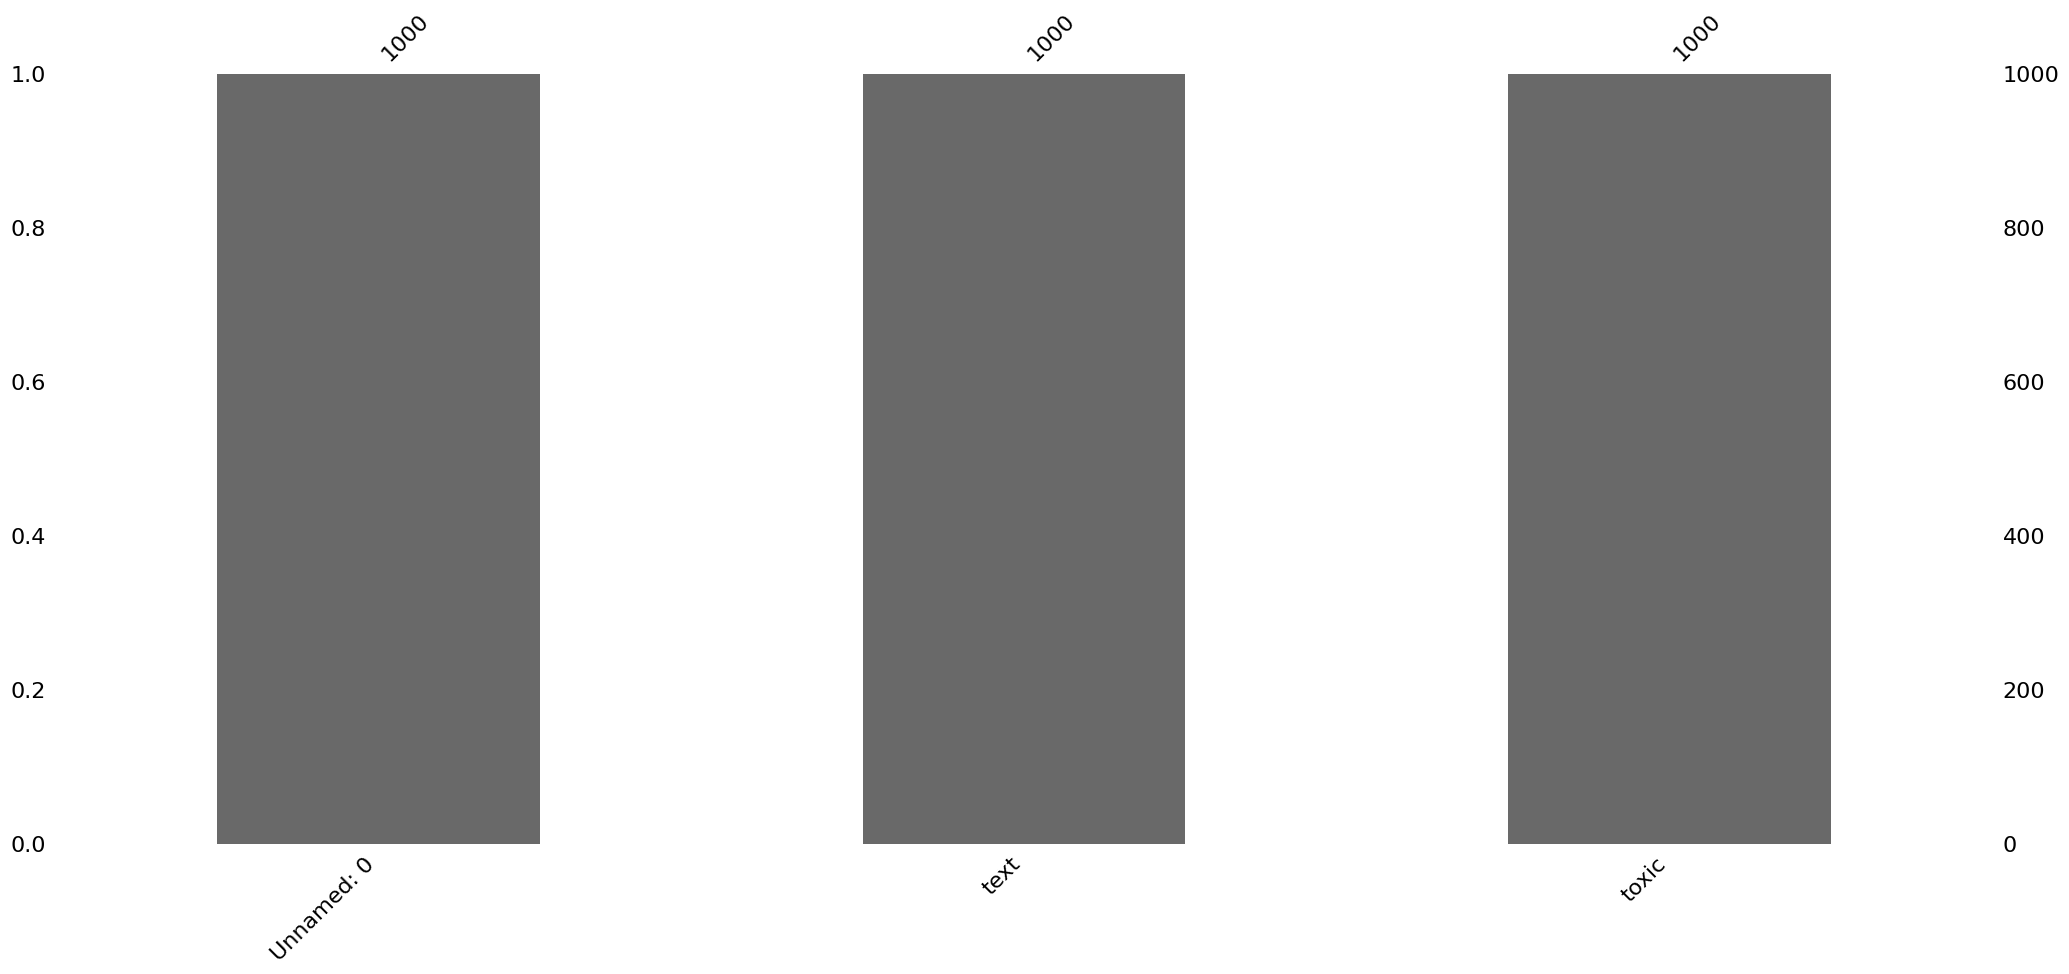

In [7]:
msno.bar(toxic_comments);

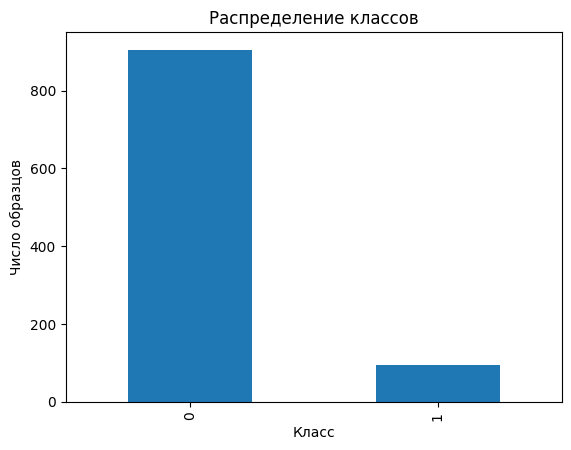

In [8]:
class_counts = toxic_comments['toxic'].value_counts()

class_counts.plot(kind='bar')
plt.title('Распределение классов')
plt.xlabel('Класс')
plt.ylabel('Число образцов')
plt.show()

In [9]:
# Оптимизация числовых типов данных
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
        # Размер занимаемой памяти до оптимизации (в Мб)
        before_size = df.memory_usage().sum() / 1024**2    
        for column in df.columns:
            column_type = df[column].dtypes
            if column_type in numerics:
                column_min = df[column].min()
                column_max = df[column].max()
                if str(column_type).startswith('int'):
                    if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                        df[column] = df[column].astype(np.int8)
                    elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                        df[column] = df[column].astype(np.int16)
                    elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                        df[column] = df[column].astype(np.int32)
                    elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                        df[column] = df[column].astype(np.int64)  
                else:
                    if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                        df[column] = df[column].astype(np.float32)
                    else:
                        df[column] = df[column].astype(np.float64)    
        # Размер занимаемой памяти после оптимизации (в Мб)
        after_size = df.memory_usage().sum() / 1024**2
        if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                             .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
        return df
optimize_memory_usage(toxic_comments, print_size=True)

Размер использования памяти: до  0.02 Mb - после  0.01 Mb (45.6%)


,Unnamed: 0,text,toxic
0,140022,I cared enough to find all the reliable source...,0
1,7427,poster \n\nI have sent the e-mail. -Garrett,0
2,23010,"""\nAs an internationalist who wants nothing mo...",0
3,13341,Why do you keep removing links from the BB 200...,0
4,132282,"""\nI guess we can't accommodate for people's i...",0
...,...,...,...
995,37814,"The account remains blocked, 72 hours later. E...",0
996,127702,"""\n\n I deleted a poorly constructed sentence....",0
997,25719,PINAPPLES DO NOT WEAR BATHROBES. THEY WEAR BRA...,1
998,39372,"""\n\n AfD notification \n\nHello. I nominated ...",0


**Вывод: В данных отсутствуют пропуски и дубликаты.**

### Шаг 3. Обучение моделей.

In [10]:
nlp = spacy.load('en_core_web_sm')

def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

tqdm.pandas()
toxic_comments['lemmatized_text'] = toxic_comments['text'].progress_apply(lemmatize_text)
toxic_comments['lemmatized_text'].head(20)

100%|██████████| 1000/1000 [00:11<00:00, 84.22it/s]


0     I care enough to find all the reliable source ...
1       poster \n\n I have send the e - mail . -Garrett
2     " \n as an internationalist who want nothing m...
3     why do you keep remove link from the BB 2006 ?...
4     " \n I guess we can not accommodate for people...
5     it would not hurt to ask the copyedit guild to...
6     " \n\n Heh , alright .   I be nearly in " " sw...
7     what be your version of IE ? — — Eagle ( ask I...
8     " \n\n  okay , then let us turn it around : I ...
9     " \n\n  IP range block \n\n hi ! how do IP ran...
10    " \n\n  your recent disruptive editing at " " ...
11                                thank . 81.100.44.233
12    you be no fun . I give up . but the edit will ...
13    " " " Banned Group lead Dissent in Egypt " " b...
14    " \n\n  Edgeworth 's Father 's Name \n\n I hav...
15    I can live with this .   I like reliably sourc...
16    I just think it come across as pushy .   no big .
17    " \n\n my civility \n you sir have not hav

In [11]:
ord_categories = ['lemmatized_text']
RANDOM_STATE = 42
TEST_SIZE = .2
X_train, X_test, y_train, y_test = train_test_split(toxic_comments['lemmatized_text'], toxic_comments['toxic'], test_size=TEST_SIZE, random_state=RANDOM_STATE)

vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

Модель LogisticRegression:

In [12]:
pipe_final = Pipeline([
    ('model', LogisticRegression(random_state=RANDOM_STATE, max_iter=100))
])

param_distributions = {
    'model__C': optuna.distributions.IntDistribution(1, 15),
    'model__solver': optuna.distributions.CategoricalDistribution(['liblinear', 'lbfgs', 'sag', 'saga']),
    'model__penalty': optuna.distributions.CategoricalDistribution(['l1', 'l2'])
}

optuna_search_lg = OptunaSearchCV(
    pipe_final,
    param_distributions,
    scoring='f1',
    n_trials=5,
    n_jobs=-1
)

optuna_search_lg.fit(X_train_tfidf, y_train)

print('Лучшая модель и её параметры:\n\n', optuna_search_lg.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', optuna_search_lg.best_score_)

C:\Users\vanya\AppData\Local\Temp\ipykernel_23796\3635780408.py:11: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search_lg = OptunaSearchCV(
[I 2024-08-02 10:16:29,268] A new study created in memory with name: no-name-d1103a25-ed54-49ca-bdd3-d0d1304bc848
[I 2024-08-02 10:16:29,338] Trial 4 finished with value: 0.39766081871345027 and parameters: {'model__C': 4, 'model__solver': 'liblinear', 'model__penalty': 'l1'}. Best is trial 4 with value: 0.39766081871345027.
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklear

Лучшая модель и её параметры:

 Pipeline(steps=[('model',
                 LogisticRegression(C=15, penalty='l1', random_state=42,
                                    solver='saga'))])
Метрика лучшей модели на тренировочной выборке: 0.43578947368421056


c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Модель DecisionTreeClassifier

In [13]:

pipe_final = Pipeline([
    ('model', DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
])

param_distributions = {
    'model__max_depth': optuna.distributions.IntDistribution(3, 20),
    'model__min_samples_split': optuna.distributions.FloatDistribution(0.01, 0.5),
    'model__min_samples_leaf': optuna.distributions.FloatDistribution(0.01, 0.5),
    'model__max_features': optuna.distributions.CategoricalDistribution(['auto', 'sqrt', 'log2'])
}

optuna_search_tree = OptunaSearchCV(
    pipe_final,
    param_distributions,
    scoring='f1',
    n_trials=8,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

optuna_search_tree.fit(X_train_tfidf, y_train)

print('Лучшая модель и её параметры:\n\n', optuna_search_tree.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', optuna_search_tree.best_score_)

C:\Users\vanya\AppData\Local\Temp\ipykernel_23796\1469577869.py:12: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search_tree = OptunaSearchCV(
[I 2024-08-02 10:16:29,932] A new study created in memory with name: no-name-eb3729f8-151d-4b2c-8f6a-3e838a8253ec
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\optuna_integration\sklearn.py:377: RuntimeWarning: Mean of empty slice
  trial.set_user_attr("mean_{}".format(name), np.nanmean(array))
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\optuna_integration\sklearn.py:377: RuntimeWarning: Mean of empty slice
  trial.set_user_attr("mean_{}".format(name), np.nanmean(array))
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\optuna_integration\sklearn.py:377: RuntimeWarning: Mean of empty slice
  trial.set_user_attr("mean_{}".format(name), np.nanmean(array))
c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\optuna_integration\sk

Лучшая модель и её параметры:

 Pipeline(steps=[('model',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=12,
                                        max_features='sqrt',
                                        min_samples_leaf=0.38307640387123876,
                                        min_samples_split=0.31269952964955416,
                                        random_state=42))])
Метрика лучшей модели на тренировочной выборке: 0.17216828478964402


Модель BERT:

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device: {device}')

Using device: cuda


In [15]:
# model_path = './bert-base-uncased'
# tokenizer_path = './bert-base-uncased'

# if os.path.exists(model_path) and os.path.exists(tokenizer_path):
#     model = BertModel.from_pretrained(model_path)
#     tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
# else:
#     tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#     model = BertModel.from_pretrained('bert-base-uncased')
#     model.save_pretrained(model_path)
#     tokenizer.save_pretrained(tokenizer_path)

# model_path = './distilbert-base-uncased'
# tokenizer_path = './distilbert-base-uncased'

# if os.path.exists(model_path) and os.path.exists(tokenizer_path):
#     model = DistilBertModel.from_pretrained(model_path)
#     tokenizer = DistilBertTokenizer.from_pretrained(tokenizer_path)
# else:
#     tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
#     model = DistilBertModel.from_pretrained('distilbert-base-uncased')
#     model.save_pretrained(model_path)
#     tokenizer.save_pretrained(tokenizer_path)

# model_path = './albert-base-v2'
# tokenizer_path = './albert-base-v2'

# if os.path.exists(model_path) and os.path.exists(tokenizer_path):
#     # Загрузка модели и токенизатора из локального хранилища
#     model = AlbertModel.from_pretrained(model_path)
#     tokenizer = AlbertTokenizer.from_pretrained(tokenizer_path)
# else:
#     # Загрузка модели и токенизатора из интернета и сохранение локально
#     model = AlbertModel.from_pretrained('albert-base-v2')
#     tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
#     model.save_pretrained(model_path)
#     tokenizer.save_pretrained(tokenizer_path)

model_name = 'unitary/toxic-bert'

model_path = './toxic-bert'
tokenizer_path = './toxic-bert'

if os.path.exists(model_path) and os.path.exists(tokenizer_path):
    model = AutoModel.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
else:
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    model.save_pretrained(model_path)
    tokenizer.save_pretrained(tokenizer_path)

In [16]:
model = model.to(device)
dataset = HFDataset.from_pandas(toxic_comments)

def tokenize_function(examples):
    return tokenizer(examples['lemmatized_text'], padding='max_length', truncation=True, max_length=512)

tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=['lemmatized_text', 'text'])
print(tokenized_datasets)
# tokenized = toxic_comments['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True))

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset({
    features: ['Unnamed: 0', 'toxic', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})


In [17]:
data_collator = DataCollatorWithPadding(tokenizer)
dataloader = DataLoader(tokenized_datasets, batch_size=32, collate_fn=data_collator, shuffle=True)
print(next(iter(dataloader)))

{'Unnamed: 0': tensor([ 74826, 128115,  79538, 140030,  70899,   1559, 116232,   7326, 149836,
         27885,  63888,  25719,  71449,  54220,  85011, 155337,  94624,  96335,
        124926, 143740,  74934,  55037,  12054, 153682, 125580,  20064, 153031,
         56580, 106223,  10957,  69017,   9776]), 'toxic': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0]), 'input_ids': tensor([[  101,  1010,  2321,  ...,     0,     0,     0],
        [  101,  1000,  2006,  ...,     0,     0,     0],
        [  101,  1000, 11209,  ...,     0,     0,     0],
        ...,
        [  101, 29038,  2131,  ...,     0,     0,     0],
        [  101,  1000,  2393,  ...,     0,     0,     0],
        [  101,  2009,  2052,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0,

In [18]:
embeddings = []
scaler = torch.cuda.amp.GradScaler(enabled=device.type == 'cuda')

with torch.no_grad():
    for batch in notebook.tqdm(dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        with torch.cuda.amp.autocast(enabled=device.type == 'cuda'):
            outputs = model(input_ids, attention_mask=attention_mask)
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        
        embeddings.append(batch_embeddings)

  0%|          | 0/32 [00:00<?, ?it/s]

c:\Users\vanya\anaconda3\envs\practicum\lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [19]:
# max_len = 512
# padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
# attention_mask = np.where(padded != 0, 1, 0)

# batch_size = 32



# for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
#     batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device)
#     attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(device)
    
#     with torch.no_grad():
#         batch_embeddings = model(batch, attention_mask=attention_mask_batch)
    
#     embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

In [20]:
features = np.concatenate(embeddings)
labels = np.array(toxic_comments['toxic'])
# toxic_comments = toxic_comments.sample(159200).reset_index(drop=True)

X_train2, X_test2, y_train2, y_test2 = train_test_split(features, labels, test_size=TEST_SIZE, random_state=RANDOM_STATE)

lg = LogisticRegression(max_iter=10000, class_weight='balanced')
lg.fit(X_train2, y_train2)

cv_scores = cross_val_score(lg, X_train2, y_train2, cv=5, scoring='f1')

print(f'Средняя F1-метрика на кросс-валидации: {cv_scores.mean()}')


Средняя F1-метрика на кросс-валидации: 0.1050999592003264


Тестирование лучшей модели:

In [21]:
# Оценка на тестовой выборке
y_pred_test = optuna_search_lg.predict(X_test_tfidf)
test_f1 = f1_score(y_test, y_pred_test)

print(f'Mетрика F1 на тестовой выборке: {test_f1}')

Mетрика F1 на тестовой выборке: 0.5789473684210527


### Шаг 4. Общий вывод

**Вывод**

1. **Задача данного проекта была в определении токсичных комментариев**

2. **В ходе предобработки данных не потребовалось ничего изменять, данные были в порядкеТак же была применена функция оптимизации числовых данных. В ходе всех обработок, объем датасета стал 1.97 мб(изначально было 3.65 мб)**

3. **Логистическая регрессия показала значение метрики f1 = 78.**

4. 